<a href="https://colab.research.google.com/github/recmit/podcast-reviews-sentiment/blob/main/vader_bert_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq transformers watermark vaderSentiment emoji datasets evaluate pickle5

     |████████████████████████████████| 5.3 MB 4.7 MB/s 
     |████████████████████████████████| 125 kB 11.3 MB/s 
     |████████████████████████████████| 216 kB 68.8 MB/s 
     |████████████████████████████████| 441 kB 58.5 MB/s 
     |████████████████████████████████| 72 kB 1.9 MB/s 
     |████████████████████████████████| 256 kB 72.1 MB/s 
     |████████████████████████████████| 7.6 MB 50.2 MB/s 
     |████████████████████████████████| 163 kB 51.1 MB/s 
     |████████████████████████████████| 115 kB 54.5 MB/s 
     |████████████████████████████████| 212 kB 54.7 MB/s 
     |████████████████████████████████| 127 kB 33.0 MB/s 
     |████████████████████████████████| 1.6 MB 46.5 MB/s 


In [ ]:
from functools import partial
import os

import pickle5 as pickle

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import emoji
import sqlite3

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Hugging Face
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, get_scheduler, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import evaluate

from tqdm.auto import tqdm

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device('cuda:0'  if torch.cuda.is_available() else 'cpu')

FINETUNED_SST = 'distilbert-base-uncased-finetuned-sst-2-english'
PRETRAINED = 'distilbert-base-uncased'

In [ ]:
%load_ext watermark
%watermark --iversions

torch         : 1.12.1+cu113
vaderSentiment: 3.3.2
numpy         : 1.21.6
pandas        : 1.3.5
evaluate      : 0.3.0
sqlite3       : 2.6.0
transformers  : 4.23.1
emoji         : 2.1.0
seaborn       : 0.11.2
matplotlib    : 3.2.2
pickle5       : 0.0.12



In [ ]:
if device.type == 'cuda':
  print(device.type, torch.cuda.get_device_name())
else:
  print(device.type)

cuda Tesla T4


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

PATH = 'drive/MyDrive/ml-projects/podcast-reviews/'

Mounted at /content/drive


# Comparing the Sentiment of Reviews and Ratings, with VADER and BERT

In another notebook we trained a collaborative filtering recommender using a million star ratings from Apple Podcasts. We didn't use the **content of the reviews**, but they are an additional source of signal of user preference. Some of that signal can be extracted using **sentiment analysis** and could then be used to train a recommender system.

The sentiment of each review is (of course) highly correlated with the rating given by the user, but **this correlation is not absolute**. For example, there are some 1 star ratings for which the review text nonetheless clearly reflects a positive user preference, but the user rated it with 1 star to bring attention to some complaint: issues with the sound, or even that no new episodes have been released in a while. The recommender which is only trained on the ratings will miss these distinctions.

We will **compare two different sentiment analysis techniques**.

### VADER
First we look **VADER**. This method associates a sentiment score to each text, which ranges from -1 for very negative text to 1 for very positive text (there are multiple scores but we use the compound score). To classify the reviews by sentiment we will need to set thresholds for this score.

VAADER consists of a bag of words approach *modified* by some heuristic rules.  The *bag of words* part refers to getting the score of a review simply by *adding* the scores of the individual words. Note that this approach would disregard the order of the words, so we can think of the words as being randomly shuffled in a metaphorical bag (of words). The problem with such a simplistic approach is that the order of the words actually matter quite a bit. This is why VADER adds some useful heuristics which take into account the order of the words to *some* extent. For example, "not" appearing closely before a word inverts the polarity of that word. The rules are explained in the original [paper](http://eegilbert.org/papers/icwsm14.vader.hutto.pdf), which is very well written and worth a read.

### BERT

The other method we will use is based on the newer and very popular BERT transformer (clearly ML researchers love puns). More precisely we will use **distilBERT**, a smaller version which is almost as precise but more efficient in both time and memory thanks to [knowledge distillation](https://en.wikipedia.org/wiki/Knowledge_distillation). What makes BERT so popular is that it was of the first large language model that was made widely accessible for people to fine-tune for their own NLP tasks. This allows us to take advantage of the enormous resources spent by Google in training BERT with general text data and simply fine-tune it for our particular use case in just hours or even minutes on a single GPU.

On Hugging Face there is a distilBERT transfomer which has already been fine-tuned for the task of sentiment analysis. They used a variation of the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/) (SST), called **SST2**. SST consists of sentences from movie reviews which have been annotated by human judges (giving sentiment scores between 0 and 1 with a slider). In the SST2 version the labels are binary (0 or 1) instead of floats.

In this notebook we will compare VADER to the distilBERT model fine-tuned on SST2. In a *separate* notebook we will **fine-tune the original pretrained distilBERT** ourselves on this podcast reviews dataset.

Fine-tuning the model ourselves will result in significantly better predictions of the sentiment, or at least the sentiment reflected by the ratings (which are our labels for training).

On the flip side, using the model fine-tuned on SST2 allows us to explore the sentiment associated with the various reviews *independently* from the ratings. We mentioned above that some 1 star ratings are actually just constructive feedback and the review content itself is mostly positive. The model trained on a different dataset (like SST2) is more likely classify those as being positive despite the low rating. In contrast, the model we train on the podcast reviews will learn to correlate the sentiment predictions with the star ratings as much as possible.

## 1. Sentiment Analysis with VADER

VADER relies on a lexicon of words, each with an associated polarity score. There are actually multiple scores but we will use **compound score**, which ranges from -1 (very negative) to 1 (very positive), and can be anywhere in between depending on the intensity of the sentiment. As mentioned in the introduction, the score of a sentence is roughly given by adding the scores of the individual words up, *except* that there are some heuristic rules. One such rule is inverting the score of a word if it is preceded by "not". Considering how simple this method is, it works surprisingly well. One helpful feature is that **the sentiment lexicon even contains emojis**, which are used in many reviews.

### 1.1 Load and Explore Data

In this section we:
- Load the data from an SQLite file.
- Compute the VADER polarity score of the reviews.
- Visualize the score distribution.
- "Demojize" the reviews (for distilBERT).
- Save the polarity scores and demojized reviews with Pickle.

First we need to load the data and save it in a Pandas DataFrame.

In [ ]:
with sqlite3.connect(os.path.join(PATH, 'data', 'database.sqlite')) as con:
  get_reviews = """SELECT author_id AS user_id, p.podcast_id, r.title, r.content, rating, p.title AS name, created_at
                              FROM podcasts p
                              INNER JOIN reviews r
                              USING(podcast_id)
                              """
  reviews_raw = pd.read_sql(get_reviews, con, parse_dates='created_at')

Next we will compute the polarity score for each review. We use the SentimentIntensityAnalyzer from vaderSentiment. The polarity score has multiple components but we only need the **compound score**.

In [ ]:
def polarity_score(text):
  sia = SentimentIntensityAnalyzer()
  return sia.polarity_scores(text)['compound']

In [ ]:
polarity_score('I did not hate the movie.')

0.4585

It even works on emojis! This is actually relevant here because some podcast reviews contain emojis.

In [ ]:
polarity_score('😊')

0.7184

Two smiley faces are better than one:

In [ ]:
polarity_score('😊😊')

0.9001

To compute one polarity score per review we will concatenate the title and the body of the review:

In [ ]:
reviews_raw['review'] = reviews_raw['title'] + '. ' + reviews_raw['content']

Now we compute the polarity score for all one million reviews, which takes a few minutes!

In [ ]:
reviews_raw['polarity score'] = reviews_raw['review'].apply(polarity_score)

To feed the reviews to distilBERT later we need to convert emojis to text. Otherwise, they will be tokenized as 'unkown' and the information will be lost. We use the `emoji` Python package.

In [ ]:
reviews_raw['demojized review'] = reviews_raw['review'].apply(emoji.demojize)

We pickle the reviews dataframe to use in other notebooks. It also makes our life easier because we don't have to repeat the computation of the polarity score (which takes over 15 minutes) every time we start a new session.

In [ ]:
reviews_raw.to_pickle(os.path.join(PATH, 'data', 'reviews_raw_sentiment.pkl'))

In [ ]:
reviews_raw = pd.read_pickle(os.path.join(PATH, 'data', 'reviews_raw_sentiment.pkl'))

In [ ]:
reviews_raw.head(2)

,user_id,podcast_id,title,content,rating,name,created_at,review,polarity score,demojized review
0,F7E5A318989779D,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,Backstage at Tilles Center,2018-04-24 12:05:16-07:00,really interesting!. Thanks for providing thes...,0.9109,really interesting!. Thanks for providing thes...
1,F6BF5472689BD12,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,Backstage at Tilles Center,2018-05-09 18:14:32-07:00,Must listen for anyone interested in the arts!...,0.9739,Must listen for anyone interested in the arts!...


Having a look at the reviews, we see that VADER does catch some reviews that show the **user actually likes the podcast but has some minor complaint** to make. In that sense, one could use VADER to get the true user preference, which the rating is not reflecting correctly in those cases. 

The following is an example of such a review. The user clearly likes the podcast yet left a 1 star rating.


In [ ]:
reviews_raw.loc[9, 'content'], reviews_raw.loc[9, 'rating']

('Great podcast, but the editors turn the volume down for the talks. The intros are loud, then you have to crank up the volume for the talk.',
 1)


However, VADER exhibits a **positivity bias** and classifies many clearly negative reviews as positive. Because of this, it is probably not precise enough to give a useful signal of user preference in addition to the user rating. We will see that the sentiment predicted by the distilBERT model is much accurate.

Below we visualize the distribution of the VADER sentiment score for negative (1 and 2 star), neutral (3 star) and positive (4 and 5 star) ratings.


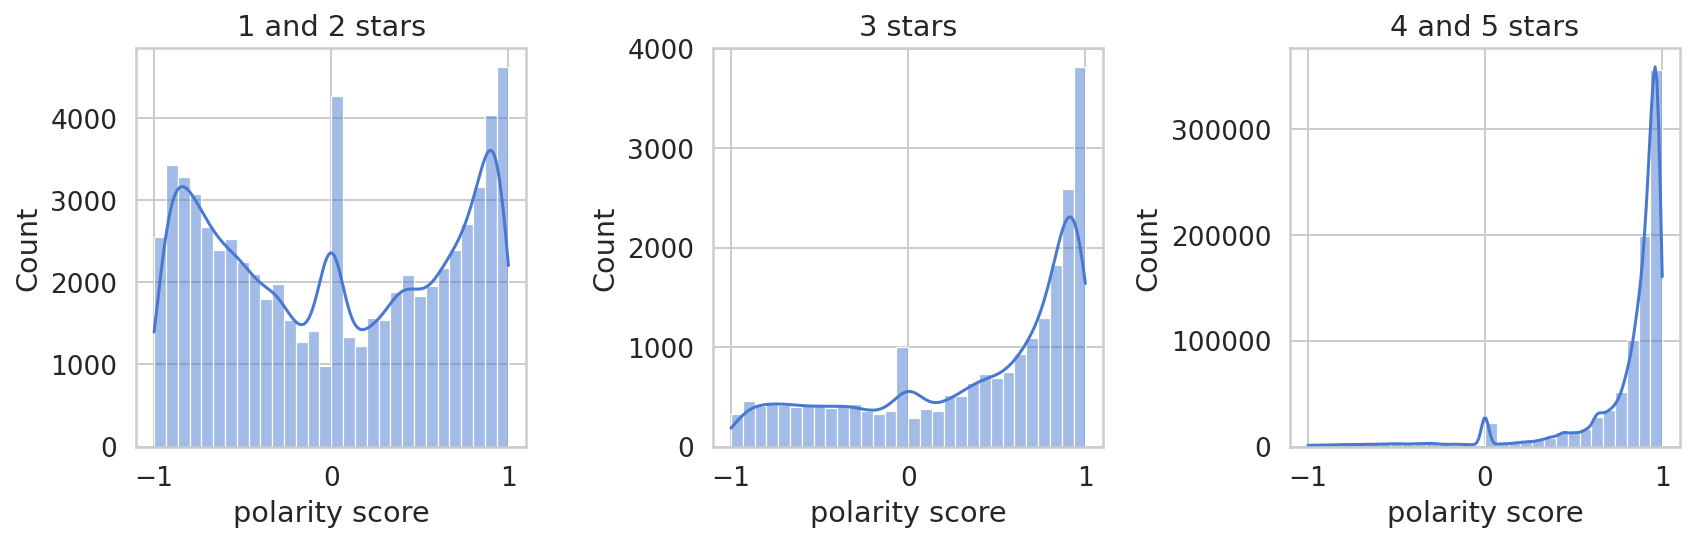

In [ ]:
def plot_histograms_by_sentiment(reviews, column_name):
  fig, axs = plt.subplots(1, 3, figsize=(12, 4))
  sns.histplot(
      reviews[reviews['rating'].isin([1, 2])][column_name],
      ax=axs[0],
      bins=30,
      kde=True,
  )
  sns.histplot(
      reviews[reviews['rating'] == 3][column_name],
      ax=axs[1],
      bins=30,
      kde=True,
  )
  sns.histplot(
      reviews[reviews['rating'].isin([4, 5])][column_name],
      ax=axs[2],
      bins=30,
      kde=True,
  )
  axs[0].set_title('1 and 2 stars')
  axs[1].set_title('3 stars')
  axs[2].set_title('4 and 5 stars')
  fig.tight_layout()
plot_histograms_by_sentiment(reviews_raw, 'polarity score')

The histograms clearly show a positivity bias. We see that even for negative ratings the mean sentiment score is just over 0:

In [ ]:
neg_mean = reviews_raw[reviews_raw['rating'].isin([1, 2])]['polarity score'].mean()
neut_mean = reviews_raw[reviews_raw['rating'] == 3]['polarity score'].mean()
pos_mean = reviews_raw[reviews_raw['rating'].isin([4, 5])]['polarity score'].mean()
print(
  f'The mean VADER compound score for 1 and 2 star reviews is {neg_mean:.2}\n'
  f'The mean VADER compound score for 3 star reviews is {neut_mean:.2}\n'
  f'The mean VADER compound score for 4 and 5 star reviews is {pos_mean:.2}'
)

The mean VADER compound score for 1 and 2 star reviews is 0.017
The mean VADER compound score for 3 star reviews is 0.37
The mean VADER compound score for 4 and 5 star reviews is 0.79


The peaks at 0 are probably reviews for which VADER can't actually identify the sentiment. Regarding the 0 scores, a word of caution: The histograms can be misleading! The reviews with score 0 seem to be a large proportion for 1 and 2 star ratings, and certainly seem to comprise much smaller proportions for the other rating values. However, we see below that the differences are actually not as dramatic as they might look in the histograms: reviews with score 0 are approximately $4\%$ for negative ratings, $3\%$ for neutral ratings, and $2\%$ for positive ratings.

In [ ]:
reviews_raw.groupby('rating').apply(lambda df: (df['polarity score'] == 0).mean())

rating
1    0.052295
2    0.035327
3    0.032470
4    0.025381
5    0.023363
dtype: float64


### 1.2 Clean Data
Some reviews appear to be spam, which is why we will remove reviews by users with suspiciously high review counts. We will also exclude some podcasts for kids because a majority of the "reviews" for those podcasts aren't actually reviews. Instead, children appear to be using the reviews as a forum in which to post jokes.

Additionally, we are writing two functions to convert both VADER polarity scores and ratings into **sentiment classes**. We will contemplate two possibilities:
- Three classes: 0 (negative), 1 (neutral) and 2 (positive).
- Binary case: 0 (negative) and 1 (positive).

The functions below can handle either case.

In [ ]:
kids_podcasts = ['Wow in the World', 'Story Pirates', 'Pants on Fire', 'The Official Average Boy Podcast', 'Despicable Me', 'Rebel Girls', 'Fierce Girls', 'Like and Subscribe: A podcast about YouTube culture', 'The Casagrandes Familia Sounds', 'What If World - Stories for Kids', 'Good Night Stories for Rebel Girls', 'Gird Up! Podcast', 'Highlights Hangout', 'Be Calm on Ahway Island Bedtime Stories', 'Smash Boom Best', 'The Cramazingly Incredifun Sugarcrash Kids Podcast']

def remove_spammers(reviews, max_reviews=135):
    'Remove users with suspiciously high review count.'
    mask = reviews.groupby('user_id')['podcast_id'].transform('count') <= max_reviews
    return reviews[mask]

def rating_to_sentiment(ratings, neutral=True):
  sentiments = np.zeros(ratings.shape)
  sentiments[ratings == 3] = 1 if neutral else 0
  sentiments[ratings > 3] = 2 if neutral else 1
  return sentiments

def vader_score_to_sentiment(polarity_scores, neg_threshold=0.4, pos_threshold=0.75):
  assert neg_threshold <= pos_threshold
  sentiments = np.zeros(polarity_scores.shape)
  sentiments[polarity_scores > neg_threshold] = 1
  if pos_threshold > neg_threshold: # otherwise there is no neutral class
    sentiments[polarity_scores > pos_threshold] = 2
  return sentiments

In [ ]:
reviews_raw['VADER sentiment'] = vader_score_to_sentiment(reviews_raw['polarity score'])
reviews_raw['sentiment'] = rating_to_sentiment(reviews_raw['rating'])
reviews_raw['binary sentiment'] = rating_to_sentiment(reviews_raw['rating'], neutral=False)

Note that in addition to cleaning the data we are taking a sample consisting of 100,000 reviews. This makes the data more manageable while still being a large enough dataset to be representative when we evaluate our sentiment classifiers. On top of that, **we sample the data in such a way that each star rating is represented equally**, to make sure that classification accuracy isn't skewed in favor of positive ratings, which constitute over $90\%$ of the original dataset.

In [ ]:
reviews_raw['sentiment'].value_counts() / reviews_raw['sentiment'].count()

2.0    0.905482
0.0    0.071179
1.0    0.023339
Name: sentiment, dtype: float64

Now we are finally ready to do the cleaning and take a 100,000 reviews sample with equal ratings representation.

In [ ]:
 reviews = (
     reviews_raw.query("name not in @kids_podcasts")
                .pipe(remove_spammers)
                .groupby('rating')
                .apply(lambda df: df.sample(n=20000))
                .sample(frac=1)
                .reset_index(drop=True)
)

### 1.3 Results for VADER Classification into Negative, Neutral, and Positive

We used the VADER score to classify reviews into those three classes based on two thresholds (which we tuned by hand to maximize accuracy).

The ratings were used as the ground truth sentiment, where 1 and 2 star ratings correspond to negative, 3 star ratings to neutral, and 4 and 5 star ratings to positive.

The following is the confusion matrix for the whole (raw) dataset.

In [ ]:
pd.crosstab(reviews_raw['VADER sentiment'], reviews_raw['sentiment'])

sentiment,0.0,1.0,2.0
VADER sentiment,,,
0.0,45084,9247,79046
1.0,11054,4525,116317
2.0,13931,9203,695998


In [ ]:
accuracy_score(reviews_raw['sentiment'], reviews_raw['VADER sentiment'])

0.757418948501887

The accuracy is relatively high but this can be misleading because in the original dataframe `reviews_raw` over $90\%$ of ratings are positive.

The recall shows that the classification is no better than chance when restricted to neutral reviews (if we picked a rating at random we would get 3 stars, i.e. neutral, $20\%$ of the time, although the fact that the recall is $19.7\%$ is probably a coincidence).

In [ ]:
recall_score(reviews_raw['sentiment'], reviews_raw['VADER sentiment'], average=None)

array([0.64342291, 0.19695321, 0.78082617])

The accuracy on the cleaned data in `reviews` is less misleading because we made sure that all ratings are equally represented with 20,000 reviews each:

In [ ]:
pd.crosstab(reviews['VADER sentiment'], reviews['sentiment'])

sentiment,0.0,1.0,2.0
VADER sentiment,,,
0.0,24394,8080,5497
1.0,6680,3930,6007
2.0,8926,7990,28496


We see that on `reviews` the accuracy is much lower but the recall is similar (it is a little lower but that might change if we choose different thresholds for the VADER score).

In [ ]:
accuracy_score(reviews['sentiment'], reviews['VADER sentiment'])

0.5682

In [ ]:
recall_score(reviews['sentiment'], reviews['VADER sentiment'], average=None)

array([0.60985, 0.1965 , 0.7124 ])

### 1.4 Optimal Threshold for VADER and Binary Sentiment

From now on we will consider a **binary** classification problem with the classes negative and positive, i.e. **discarding the neutral category**. We do this because the fine-tuned distilBERT model we are using is only a binary classifier. Note: In a separate notebook we will train distilBERT to predict the ratings, which would allow us to have a neutral class or even just 5 classes (the ratings themselves).

It seems clear that reviews with 1 or 2 stars should be considered negative and reviews with 4 and 5 stars positive. The question is *how to classify the 3 star reviews*. While VADER mostly gives them positive scores, we will see that the distilBERT model actually mostly classifies them as negative. From reading some of the 3 star reviews it does appear that the distilBERT model is right and we already noted that VADER has a positivity bias.

To classify the reviews into two classes using VADER we just have a single threshold: everything to the left of it is negative and everything to the right positive. With the following function we will find the **threshold resulting in the highest possible classification accuracy**, given a list of VADER scores and corresponding ground truth sentiments. *This is just intended as a baseline for the distilBERT model and is not a principled way to tune VADER, since this threshold probably has a high variance and we are overfitting on our training set.*

In [ ]:
def find_best_split(reviews, score_col='polarity score', sentiment_col='binary sentiment'):
  sorted_df = (
    reviews.sort_values(by=score_col)
           [[score_col, sentiment_col]]
  )
  scores = sorted_df[score_col]
  sentiments = sorted_df[sentiment_col]
  correct_class = max_correct = sentiments.sum()
  optimal_thresh = prev_score = -1
  count = 0
  for score, sentiment in zip(scores, sentiments):
    if sentiment == 0:
      correct_class += 1
    else:
      if score != prev_score and correct_class > max_correct:
        optimal_thresh = prev_score
        max_correct = correct_class
      correct_class -= 1
    prev_score = score
  if correct_class > max_correct:
    optimal_thresh = score
    max_correct = correct_class
  return {'threshold': optimal_thresh, 'accuracy': max_correct / scores.size}


First we will define 3 star ratings as negative (in fact, we already did this when we computed the 'binary sentiment' column above).

In [ ]:
best_split = find_best_split(reviews)
best_split

{'threshold': 0.7945, 'accuracy': 0.71772}

Next let's think of 3 star ratings as positive instead (we call it *alternative binary sentiment*).

In [ ]:
reviews['alt binary sentiment'] = reviews['rating'].map({1:0,2:0,3:1,4:1,5:1})
print(find_best_split(reviews, sentiment_col='alt binary sentiment'))
reviews = reviews.drop(columns='alt binary sentiment');

{'threshold': 0.296, 'accuracy': 0.70864}


Considering 3 star reviews to be positive instead of negative made virtually no difference to the accuracy. This is a little surprising because VADER tends to give 3 star reviews positive sentiment scores. The reason that the accuracy doesn't improve is that a lower threshold results in a lower recall for negative ratings, on which VADER also has a positivity bias.

Below we compute the recall. It isn't great but not terrible either considering the simplicity of the VADER method and the difficulty of the task. However, distilBERT will do better and without the need to fine-tune it on our data (although, as I mentioned, we will fine-tune it in a separate notebook and the accuracy will improve significantly).

In [ ]:
recall_score(reviews['polarity score'] >= best_split['threshold'], reviews['binary sentiment'], average=None)

array([0.77318932, 0.6405552 ])

## 2. BERT for Sentiment Classification

As mentioned in the introduction, we are using a distilBERT model [fine-tuned](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) on the SST2 dataset consisting of sentences from movie reviews.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(FINETUNED_SST)
bert_model = AutoModelForSequenceClassification.from_pretrained(FINETUNED_SST)

Before being fed to the transformer we need to tokenize the text. Tokens often correspond to full words but can also correspond to parts of words (this happens for rare words) or symbols like punctuation.

The maximum length the transformer can handle is 512 so we will have to clip particularly long reviews. In fact, we will set a lower maximum than that to improve performance. A single long review would mean we have to make the whole batch longer (the lengths of the samples in the batch must agree and the shorter ones are filled with placeholder tokens) and this uses more memory on the GPU and requires more computations.

The cutoff should be larger than the length of the overwhelming majority of reviews, to make sure it has negligible effect on the precision of the model. To determine this cutoff we will plot the length distribution.

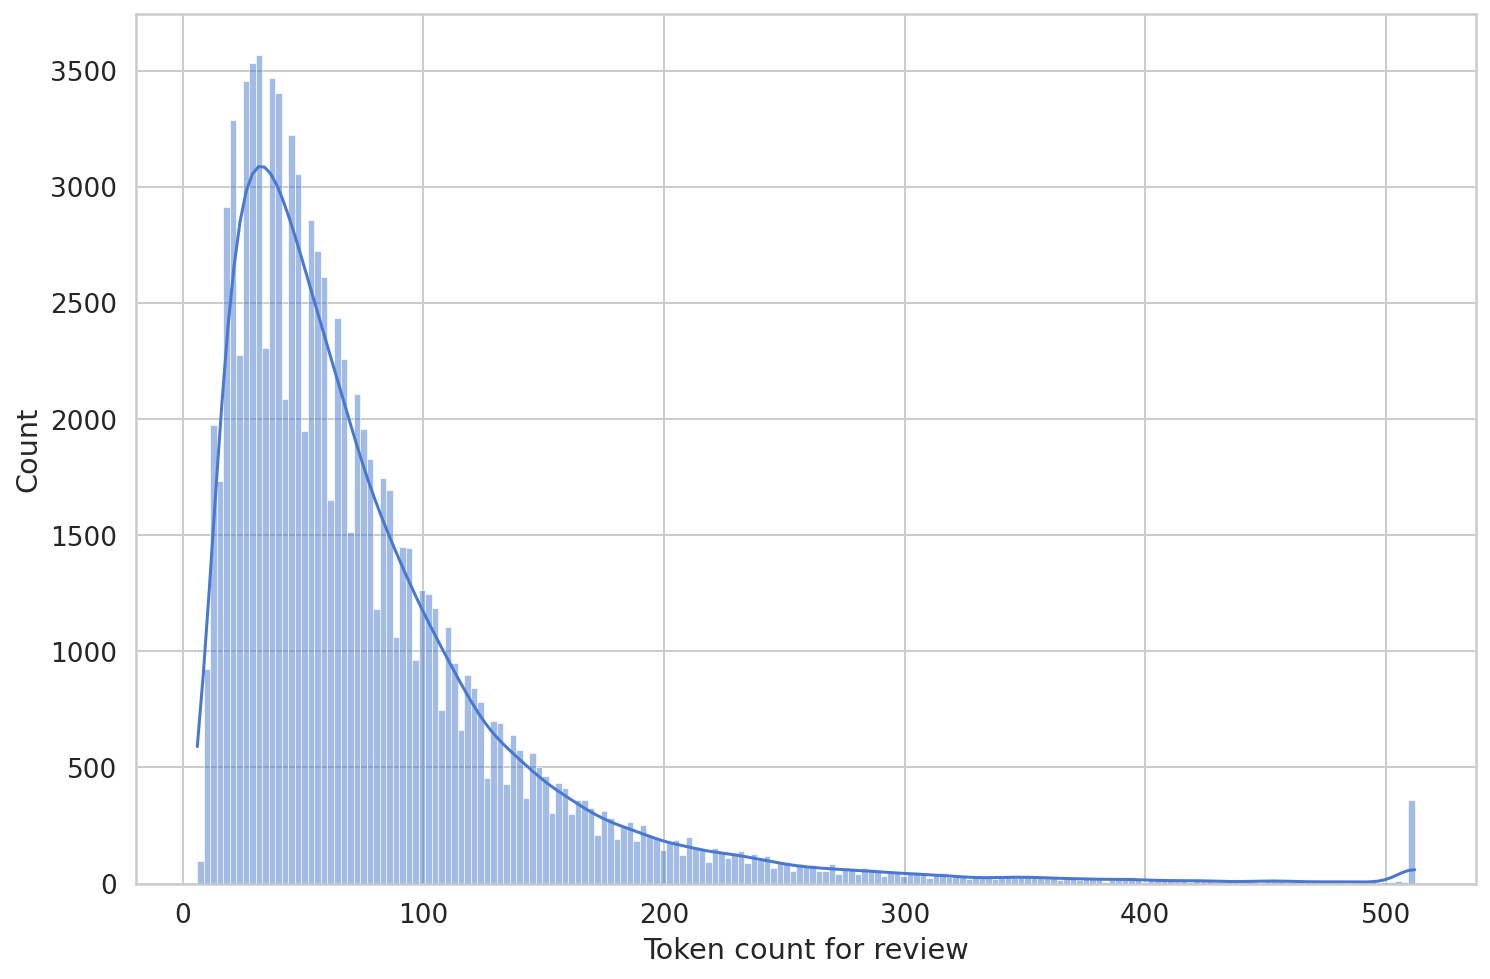

In [ ]:
token_lengths = np.array([len(tokenizer.encode(s, truncation=True, max_length=512)) for s in reviews['demojized review']])
sns.histplot(token_lengths, kde=True)
plt.xlabel('Token count for review');

In [ ]:
f'Just {(np.array(token_lengths) >= 256).mean()*100:.2} percent of the reviews have a length over 256'

'Just 2.7 percent of the reviews have a length over 256'

Now we take the **demojized reviews** from the `reviews` dataframe, **tokenize** them with a **maximum length of 256 tokens** and create a dataloader which will feed the tokenized samples in batches of size 32 to the distilBERT classifier.

In [ ]:
def tokenize_function(data, tokenizer, max_length=256):
    return tokenizer(data['demojized review'], truncation=True, max_length=max_length)

dataset = Dataset.from_dict(reviews[['demojized review']])

tokenized_dataset = (
    dataset.map(partial(tokenize_function, tokenizer=tokenizer), batched=True)
           .remove_columns(['demojized review'])
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

dataloader = DataLoader(
    tokenized_dataset, batch_size=32, collate_fn=data_collator
)

The distilBERT model outputs the logits for the targets 0 (negative) and 1 (positive). The following function evaluates the model on a dataloader and returns an array of **probabilities** for the reviews fed through the dataloader being **positive**.

In [ ]:
def get_probs(model, dataloader):
  probs = []
  model = model.to(device)
  model.eval()
  m = nn.Softmax(dim=1)
  for batch in tqdm(dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)
      logits = outputs.logits
      probs += m(logits)[:,1].tolist()
  return np.array(probs)

In [ ]:
reviews['BERT probs'] = get_probs(bert_model, dataloader)

  0%|          | 0/3125 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


## 3. Comparing VADER and BERT

We see in the following histograms that distilBERT classifies most 3 star ratings as negative. **This is interesting because VADER does the complete opposite**, assigning overwhelmingly positive scores to 3 star reviews.

Something else to note is that this model is **very confident in its predictions**, with two sharp peaks around 0 and 1 but very little in between. We can see a little less confidence for 3 star ratings. Those are the most mixed reviews in terms of sentiment and they do exhibit some more intermediate probability values than other star ratings. However, the VADER score does a much better job as a continuous measure of sentiment outside of 0 and 1. To be fair, the distilBERt classifier is intended to make correct binary predictions, not to quantify uncertainty.

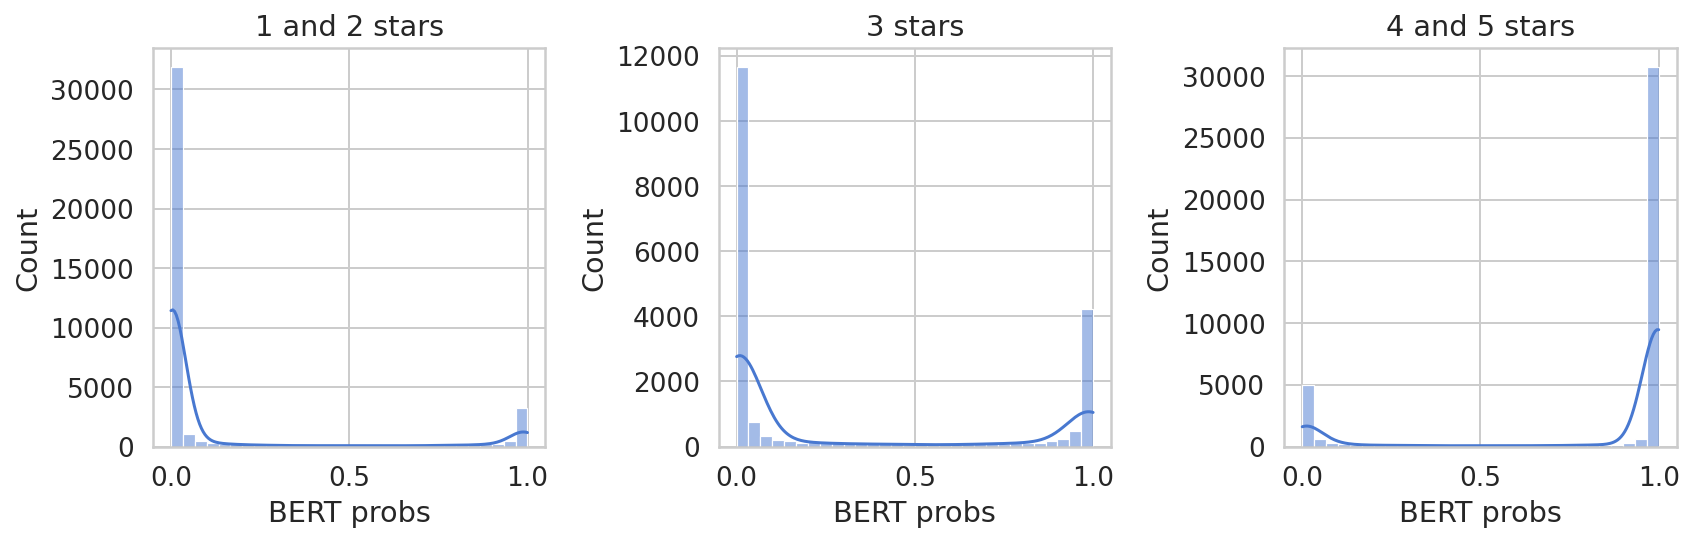

In [ ]:
plot_histograms_by_sentiment(reviews, 'BERT probs')

Most times when VADER and distilBERT disagree, the latter is right. This is not surprising because distilBERT is a much more complicated and computation intensive technique.

The following is a typical example which has a very high VADER score yet very low BERT probability of being positive (and BERT is right).


In [ ]:
reviews.loc[945, ['title', 'content', 'rating', 'polarity score', 'BERT probs']]

title                                              Used to be great
content           Used to be a great comedy podcast, until, in s...
rating                                                            1
polarity score                                               0.9509
BERT probs                                                 0.022963
Name: 945, dtype: object

In [ ]:
reviews.loc[945, 'review']

'Used to be great. Used to be a great comedy podcast, until, in someone\'s infinite wisdom, decided to replace the only talent on that "network".'


The reason the VADER score is so high for that review is that it contains many words with positive sentiment (great, wisdom, talent) and not really any words with negative sentiment (in isolation). The distilBERT model however is able to take into account the context of the whole sentence ("used to be", "the only talent").

Let's look at the reviews with high probability of being positive according to distilBERT but a very negative VADER score, and vice versa.

We see below that there are very few cases in the former category but many in the latter. The distilBERT model is usually right but certainly not every time.

Actually going through the reviews one gets the impression that those numbers underestimate how much better distilBERT is to VADER. In many cases the review sentiment is only loosely correlated with the rating. As such, some "misclassifications" by distilBERT could even be seen as additional signal to the ratings rather than mistakes.

In [ ]:
reviews.loc[(reviews['BERT probs'] > 0.95) & (reviews['polarity score'] < -0.9), 'rating'].value_counts()

4    17
3    17
1    16
2    13
5    13
Name: rating, dtype: int64

In [ ]:
reviews.loc[(reviews['BERT probs'] < 0.05) & (reviews['polarity score'] > 0.9), 'rating'].value_counts()

3    1753
2    1731
1     871
4     769
5      74
Name: rating, dtype: int64

Here are some 3 star reviews that distilBERT classifies as positive.

In [ ]:
reviews[(reviews['BERT probs'] > 0.99) & (reviews['rating'] == 3)][['title', 'content', 'rating', 'polarity score', 'BERT probs']].head(10)

,title,content,rating,polarity score,BERT probs
50,☺️,Love the podcast!! You guys keep me entertained!!,3,0.9015,0.999867
54,Great content… Please work on format,I love this podcast - the information is so va...,3,0.9890,0.993949
62,"Cool, but...",Smart and funny pod. She gets a little condesc...,3,0.8422,0.996883
221,conservatives might pass on this,I've been listening to this podcast for years ...,3,0.3679,0.995914
459,Hi it’s me and my family,Lion and cat cat dog cat cat,3,0.0000,0.998568
466,JUST WOW!,"It’s like making a murderer REVERSED, this sou...",3,0.9485,0.998971
470,Another re-run?,Are you guys ever going to get back to creatin...,3,0.3076,0.998778
473,Keep it up,"Hey, I'm a follow controller I like where this...",3,0.3612,0.998447
542,Overuse of “incredible”,I love these people but every other word Mallo...,3,0.3818,0.996635
584,my opinion,I love this podcast but you guys sidetrack way...,3,0.3818,0.991521


On the other hand, here is an example of a 3 star review that distilBERT classifies as negative.

In [ ]:
reviews[(reviews['BERT probs'] < 0.01) & (reviews['rating'] == 3)][['title', 'content', 'rating', 'polarity score', 'BERT probs']].head(10)

,title,content,rating,polarity score,BERT probs
6,"Used to be great, now is just okay",I preferred the old format. Loved hearing from...,3,0.8151,0.004110
8,Okay...,Cool I guess but I can't download any songs cu...,3,0.7391,0.007136
15,Maz,Bring him back please. Not a good move. Los...,3,-0.1546,0.005427
17,Decent content,"Overall the content is good and timely, but th...",3,-0.7420,0.000644
22,You should,"Do an interview with Not The Worst Show, it co...",3,0.7575,0.001318
38,Addictive but trashy,I listened to most of the first season. It's a...,3,0.9111,0.000854
41,Basically two guys catching a buzz......,These guys seem to have a grasp on what a beer...,3,0.3498,0.000442
76,not as good anymore,The episodes were never as long as I wanted th...,3,0.8948,0.004767
78,Inconsistent,The shows vary from top shelf to really weak d...,3,-0.5563,0.000442
80,Enjoy...Except for the Recyling,I subscrobe to the show and enjoy it quite a b...,3,0.3716,0.006824


Looking at the reviews, there is a clear difference between the ones classified as positive and those classified as negative, even though all of them come with 3 star ratings. **This exemplifies one way in which the review sentiment can give us additional signal of user preference.**

Now let's look at 1 and 2 star rating reviews that distilBERT classifies as positive. We can see that many of them talk about how they *used to* love the show, which confuses the model. Others complain about politics. We will see that at least anecdotally the distilBERT we fine-tune on this dataset will do better on those types of reviews that are common within this dataset.

In [ ]:
reviews[(reviews['BERT probs'] > 0.99) & reviews['rating'].isin([1, 2])][['title', 'content', 'rating', 'polarity score', 'BERT probs']].head(10)

,title,content,rating,polarity score,BERT probs
4,Why,Why would you trust anything from MSNBC? They ...,2,0.7096,0.990558
122,Lurched Right,Good folks. What happened to them at Evergreen...,2,0.5794,0.992818
239,Great Content but....,I love the idea of this show and listen to oth...,2,0.9259,0.998793
255,No more Monica,"I’m certain you are a good person, and I would...",2,0.9603,0.998205
285,Wanted to like this...,"Yikes, combine cheerful ignorance with minimal...",2,0.7331,0.996498
418,hope Mr Black acknowledges the REAL creators o...,"If you want to hear this done properly, listen...",1,0.8689,0.993219
492,More of the Same Now,I used to absolutely love Invisibilia. The ep...,1,0.8858,0.993986
523,Tip very intelligent butttttt!!!,Tip you have to let your guests speak to have ...,1,0.9429,0.995483
551,"Well, So Much For That","When I first saw this podcast, I was VERY exci...",2,0.9633,0.995017
713,And That’s Why You’re Awesome,I have been listening to ATWWD for over a year...,2,0.9714,0.999869


Finally these are some 4 and 5 star rating reviews that distilBERt classifies as negative. We can see that it is mostly 4 star reviews and furthermore they all seem to be complaining. It makes sense that distilBERT would classify them as negative.

In [ ]:
reviews[(reviews['BERT probs'] < 0.01) & reviews['rating'].isin([4, 5])][['title', 'content', 'rating', 'polarity score', 'BERT probs']].head(10)

,title,content,rating,polarity score,BERT probs
20,Great but....,The interview with that Nolan guy was too anno...,4,0.8916,0.001526
58,Are u dumb,Yo flip release podcast audio already facts!!!...,4,-0.3348,0.001746
61,New listener,People have tried to get me interested in podc...,5,0.6908,0.001139
106,Up speak?!,The show content is really interesting? But th...,4,0.3981,0.000748
222,sound issues,i love the words when the sound is good enough...,4,0.1862,0.009301
244,Great storytelling,I really like this podcast but I gotta admit t...,4,0.8589,0.008216
257,Weird music over talking,Jan. 7 episode has some weird loud music over ...,4,-0.5204,0.006214
318,I do like this podcast...,"I really like this podcast, however, John has ...",4,0.6953,0.001644
333,Bananas...NOOOOOwaaahhhh....,"Let me say, I absolutely love the MFM podcast ...",4,-0.8815,0.002038
442,Hoping season 4 is a return to form,Seasons 1 & 2 were utter brilliance. Season 3 ...,4,0.3167,0.004957
